In [20]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from matplotlib.patches import Patch
import numpy as np
from scipy.stats import ttest_1samp
from matplotlib.colors import to_rgba
from matplotlib import cm

In [80]:
from scipy.stats import ttest_ind
comp_memo_wer = [42.14, 41.58, 41.13, 40.61]
comp_no_memo_wer = [43.36, 43.50, 42.37, 42.56]

# Perform two-sided t-test
t_stat, p_two_sided = ttest_ind(comp_memo_wer, comp_no_memo_wer, equal_var=False)

# Convert to one-sided p-value (testing if memo < no_memo)
if t_stat < 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1 - p_two_sided / 2


print(f"One-sided p-value (memo < no_memo): {p_one_sided:.4f}")

One-sided p-value (memo < no_memo): 0.0054


In [88]:
np.mean(comp_no_memo_wer)

42.9475

In [87]:
np.mean(comp_memo_wer)

41.364999999999995

In [86]:
(np.mean(comp_no_memo_wer) - np.mean(comp_memo_wer))/np.mean(comp_no_memo_wer) * 100

3.684731358053445

In [42]:
with open("/Users/ebrahimfeghhi/Documents/neurips_2025/local_results/paper_results/neurips_transformer_time_masked_held_out_days_2_per_memo.pkl", "rb") as f:
    data = pickle.load(f)

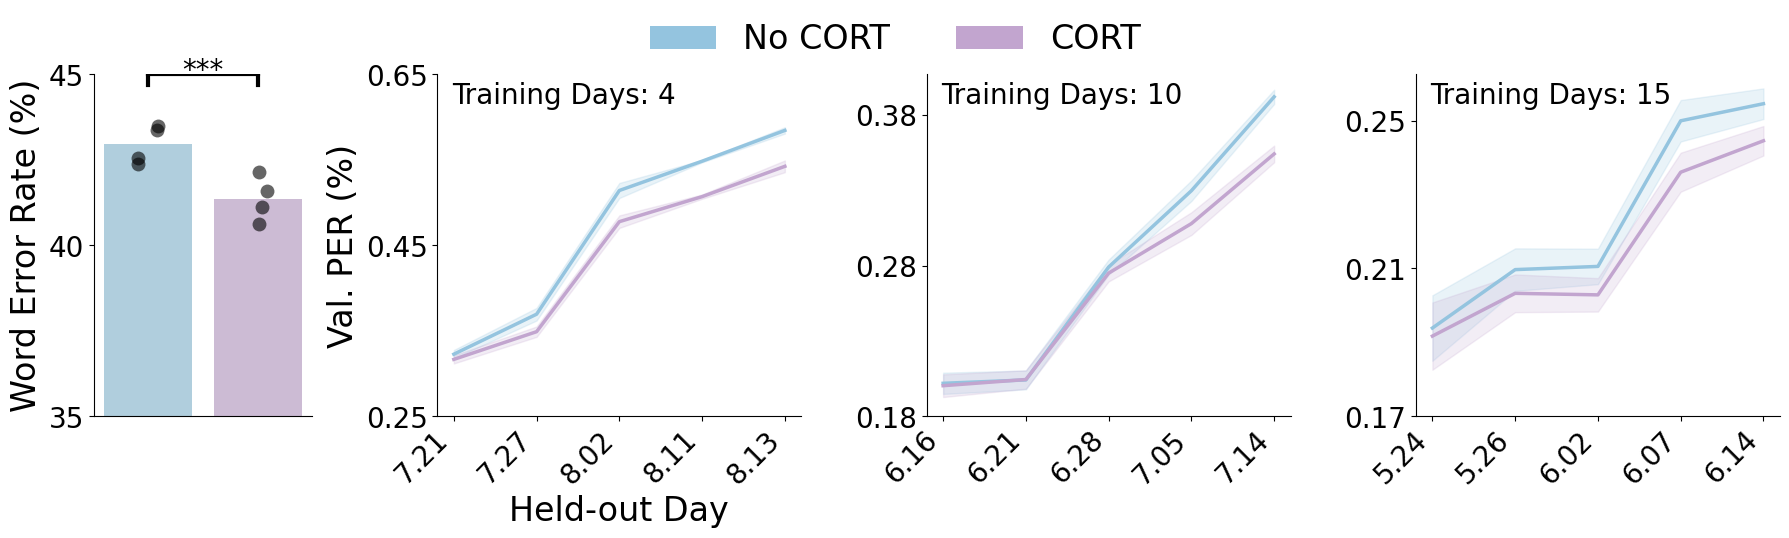

In [96]:
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_rgba
from scipy.stats import sem
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Data for bar plot
comp_memo_wer = [42.14, 41.58, 41.13, 40.61]
comp_no_memo_wer = [43.362, 43.497, 42.374, 42.563]

# Load PER files
base_dir = os.path.expanduser("~/Documents/neurips_2025/local_results/paper_results")
per_files = glob.glob(os.path.join(base_dir, "*per*.pkl"))

all_results = []
for file in per_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
    for seed, perf in data.items():
        perf = np.array(perf)
        df = pd.DataFrame({
            "Day": np.arange(len(perf)),
            "Performance": perf,
            "Seed": seed,
            "File": os.path.basename(file).replace(".pkl", "")
        })
        all_results.append(df)
df_all = pd.concat(all_results)

def get_category(filename):
    if "held_out_days_1" in filename:
        return "held_out_days_1"
    elif "held_out_days_2" in filename:
        return "held_out_days_2"
    else:
        return "held_out_days"
df_all["Category"] = df_all["File"].apply(get_category)

# Color palette
colors = cm.Blues(np.linspace(0.2, 0.5, 4))
colors[-1] = to_rgba("#c2a5cf")  # Custom color for TTA
tta_color = colors[-1]
no_tta_color = colors[2]

# Create the figure with 4 subplots
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(18, 5))
gs = GridSpec(1, 4, width_ratios=[0.6, 1, 1, 1])  # make first subplot narrower
axs = [fig.add_subplot(gs[i]) for i in range(4)]

# ---- First subplot: Bar + Strip ----
df_bar = pd.DataFrame({
    'WER': comp_memo_wer + comp_no_memo_wer,
    'Condition': ['Memo'] * len(comp_memo_wer) + ['No Memo'] * len(comp_no_memo_wer)
})
order = ['No Memo', 'Memo']

sns.barplot(
    data=df_bar,
    x='Condition', y='WER',
    palette=[tta_color, no_tta_color],
    order=order, hue='Condition',
    ax=axs[0], errorbar=None, legend=False, alpha=0.8
)
sns.stripplot(
    data=df_bar,
    x='Condition', y='WER',
    color='black', size=10, jitter=0.1,
    order=order, ax=axs[0], alpha=0.6
)
axs[0].set_title('')
axs[0].set_xlabel('')
axs[0].set_ylabel('Word Error Rate (%)', fontsize=24)
axs[0].set_xticks([])
axs[0].tick_params(axis='x', bottom=False)
axs[0].set_yticks([35, 40, 45])
axs[0].set_ylim(35, 45)
axs[0].tick_params(axis='y', labelsize=20)
sns.despine(ax=axs[0])
# Coordinates for annotation
x1, x2 = 0, 1  # indices of the bars
bar_height = 0.5
y = max(df_bar['WER']) + 1.2
tick_height = 0.3

# Bar positions
x1, x2 = 0, 1

# Draw vertical ticks
axs[0].plot([x1, x1], [y, y + tick_height], color='black', linewidth=3)
axs[0].plot([x2, x2], [y, y + tick_height], color='black', linewidth=3)

# Draw horizontal line connecting ticks
axs[0].plot([x1, x2], [y + tick_height, y + tick_height], color='black', linewidth=3)


# Add significance stars centered above the line
axs[0].text((x1 + x2) / 2, y, '***',
            ha='center', va='bottom', fontsize=20)

# ---- Remaining 3 subplots: Line plots ----
categories = ["held_out_days", "held_out_days_1", "held_out_days_2"]
xtick_labels = {
    "held_out_days": ['5.24', '5.26', '6.02', '6.07', '6.14'],
    "held_out_days_1": ['6.16', '6.21', '6.28', '7.05', '7.14'],
    "held_out_days_2": ['7.21', '7.27', '8.02', '8.11', '8.13'],
}

training_days = [4, 10, 15]

for ax, category in zip(axs[1:], categories[::-1]):
    df_cat = df_all[df_all["Category"] == category]
    summary = df_cat.groupby(["File", "Day"]).agg(
        mean_perf=("Performance", "mean"),
        sem_perf=("Performance", sem)
    ).reset_index()
    
    

    for file_name, group in summary.groupby("File"):
        color = tta_color if "memo" in file_name.lower() else no_tta_color
        ax.plot(group["Day"], group["mean_perf"], color=color, linewidth=2.5)
        ax.fill_between(group["Day"],
                        group["mean_perf"] - 1.96 * group["sem_perf"],
                        group["mean_perf"] + 1.96 * group["sem_perf"],
                        color=color, alpha=0.2)

    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(xtick_labels[category], rotation=45, ha='right', fontsize=20)
    
    training_day = training_days.pop(0)  # assuming order matches reversed categories
    ax.text(0.04, 0.98, f"Training Days: {training_day} ",
            transform=ax.transAxes, ha='left', va='top', fontsize=20)
    
    ax.set_title("")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    yticks = ax.get_yticks()
    ax.set_yticks(yticks[::4])
    ax.tick_params(axis='y', labelsize=20)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Only leftmost plot has ylabel
axs[1].set_xlabel("Held-out Day", fontsize=24)
axs[1].set_ylabel("Val. PER (%)", fontsize=24)
axs[2].set_ylabel('')
axs[3].set_ylabel('')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=tta_color, edgecolor='none', label='CORT'),
    Patch(facecolor=no_tta_color, edgecolor='none', label='No CORT')
]
fig.legend(
    handles=legend_elements[::-1],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=2,
    frameon=False,
    fontsize=24
)

plt.tight_layout()
plt.savefig(
    "/Users/ebrahimfeghhi/Documents/neurips_2025/local_figures/figure4.pdf",
    bbox_inches='tight'
)
plt.show()


In [9]:
# Time for transformer patch:  0.013015163540840148 0.011692994680188105
# Time for transformer full: 0.023417877554893492 0.011942543941788874
# Time for GRU full: 0.03564354693889618 0.00732377763754881

# N = 2000

# Transformer Patch Peak Memory: 0.39 GiB
# Transformer Peak Memory: 0.68 GiB
# GRU Peak Memory: 2.13 GiB

memory_peak = [2.13, 0.68, 0.39]
time_for_memo = [0.036, 0.023, 0.013]

In [ ]:

memory_peak = [2.13, 0.68, 0.39]
time_for_memo = [0.036, 0.023, 0.013]
